In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp
import seaborn as sns
from copy import deepcopy
from jaxopt import ProjectedGradient

The first text cell

# Setting up and testing some infrastructure (feel free to skip to next heading)


In [2]:
def randomized_pipage_rounding(x):
    """
    Fast pipage rounding implementation for uniform matroid

    From https://github.com/bwilder0/clusternet
    See Randomized Pipage Rounding algorithm in http://arxiv.org/abs/1711.01566
    """
    i = 0
    j = 1
    x = onp.array(x)  # does this make a deepcopy?
    x = deepcopy(x)  # x.clone()
    for t in range(len(x) - 1):
        if x[i] == 0 and x[j] == 0:
            i = max((i, j)) + 1
        elif x[i] + x[j] < 1:
            if onp.random.rand() < x[i] / (x[i] + x[j]):
                x[i] = x[i] + x[j]
                x[j] = 0
                j = max((i, j)) + 1
            else:
                x[j] = x[i] + x[j]
                x[i] = 0
                i = max((i, j)) + 1
        else:
            if onp.random.rand() < (1 - x[j]) / (2 - x[i] - x[j]):
                x[j] = x[i] + x[j] - 1
                x[i] = 1
                i = max((i, j)) + 1

            else:
                x[i] = x[i] + x[j] - 1
                x[j] = 1
                j = max((i, j)) + 1
    return x

In [3]:
x = jnp.array([0.1, 0.3, 0.4, 0.8, 0.4])
sum(x) + 1

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Array(3., dtype=float32)

In [4]:
# quick confirmation the rounding() produces the correct marginals

reps = 1000
total = jnp.zeros_like(x)
for i in range(reps):
    total += randomized_pipage_rounding(x)
total / reps - x

Array([-0.02      , -0.01700002,  0.01199999, -0.00200003,  0.02699998],      dtype=float32)

In [5]:
def prospective_loss(prob_win, winners, num_winners_per_lottery):
    """
    Bailey: this implements a slightly different loss than the
    one you wrote up in your initial note. In your initial note,
    the expected loss at time t is unconditional on the actual
    outcomes of the first (t-1) rounds, but here I use that
    information. I'll write this loss at nice at some point.
    """

    # if jnp.any(prob_win < 0) or jnp.any(prob_win > 1):
    #     raise ValueError("Entries of `prob_win` must be contained in [0, 1]")

    # if num_winners_per_lottery != prob_win.sum():
    #     raise ValueError(f"`prob_win` ({prob_win.sum()}) must sum to the `num_winners_per_lottery` ({num_winners_per_lottery})")

    total_attendances = winners.sum(axis=1)
    num_entrants = winners.shape[0]
    lotteries_so_far = winners.shape[1]

    # fair_allocation_so_far = num_winners_per_lottery * lotteries_so_far / num_entrants
    # print(f"num slots per lottery {num_winners_per_lottery}, attendees per lottery: {num_entrants}, lotteries so far: {lotteries_so_far}, fair allocation so far = {fair_allocation_so_far}")

    # loss_so_far = jnp.max(jnp.abs(total_attendances - fair_allocation_so_far))
    expected_attendances = total_attendances + prob_win
    fair_allocation = num_winners_per_lottery * (lotteries_so_far + 1) / num_entrants

    # we get hit by jensen's inequality when computing this expected loss given prob_win
    # but i'm going to ignore that for now
    individual_deviations = expected_attendances - fair_allocation
    expected_loss = jnp.max(jnp.abs(individual_deviations))
    return expected_loss

In [6]:
pi_test = jnp.array([0.6, 0.4, 0.5, 0.1, 0.01, 0.89, 0.5])
num_winners_per_lottery = pi_test.sum()

winners = [randomized_pipage_rounding(jnp.array(pi_test)) for _ in range(100)]
winners = jnp.column_stack(winners)

prospective_loss(pi_test, winners, num_winners_per_lottery=3)

Array(49.604286, dtype=float32)

In [7]:
def projection_simplex_clip(r, simplex_sum):
    """
    Projects a real-valued vector onto the simplex, with the constraint the elements
    of the simplex sum to ``simplex_sum,`` and all entries of the vector must
    be between 0 and 1.

    Modified from http://www.ryanhmckenna.com/2019/10/projecting-onto-probability-simplex.html

    jaxopt.projection.projection_simplex(scale=num_winners_per_lottery) doesn't quite work for us
    because it allows potential attendees to be assigned marginal probabilities of attendance
    larger than one

    """
    lambdas = jnp.append(-r, 1 - r)
    idx = jnp.argsort(lambdas)
    lambdas = lambdas[idx]
    active = jnp.cumsum((idx < r.size) * 2 - 1)[:-1]
    diffs = jnp.diff(lambdas, n=1)
    totals = jnp.cumsum(active * diffs)
    # i = jnp.searchsorted(totals, 1.0)
    # lam = (1 - totals[i]) / active[i] + lambdas[i+1]
    i = jnp.searchsorted(totals, simplex_sum)
    lam = (simplex_sum - totals[i]) / active[i] + lambdas[i + 1]
    # NOTE: i added some additional renormalization here
    p = jnp.clip(r + lam, 0, 1)
    return p / p.sum() * simplex_sum

In [8]:
num_winners_per_lottery = 3

pg = ProjectedGradient(fun=prospective_loss, projection=projection_simplex_clip)
pg_sol = pg.run(
    init_params=pi_test,
    hyperparams_proj=num_winners_per_lottery,
    winners=winners,
    num_winners_per_lottery=num_winners_per_lottery,
)
pg_sol.params

Array([0.74833333, 0.5483333 , 0.6483333 , 0.2483334 , 0.15833342,
       0.        , 0.6483333 ], dtype=float32)

In [9]:
def simplex_clip_prospective_loss(prob_win, winners, num_winners_per_lottery):

    # if jnp.any(prob_win < 0) or jnp.any(prob_win > 1):
    #     raise ValueError("Entries of `prob_win` must be contained in [0, 1]")

    # if num_winners_per_lottery != prob_win.sum():
    #     raise ValueError(f"`prob_win` ({prob_win.sum()}) must sum to the `num_winners_per_lottery` ({num_winners_per_lottery})")

    total_attendances = winners.sum(axis=1)
    num_entrants = winners.shape[0]
    lotteries_so_far = winners.shape[1]

    # fair_allocation_so_far = num_winners_per_lottery * lotteries_so_far / num_entrants
    # print(f"num slots per lottery {num_winners_per_lottery}, attendees per lottery: {num_entrants}, lotteries so far: {lotteries_so_far}, fair allocation so far = {fair_allocation_so_far}")

    # loss_so_far = jnp.max(jnp.abs(total_attendances - fair_allocation_so_far))
    expected_attendances = total_attendances + prob_win
    fair_allocation = num_winners_per_lottery * (lotteries_so_far + 1) / num_entrants

    # we get hit by jensen's inequality when computing this expected loss given prob_win
    # but i'm going to ignore that for now
    individual_deviations = expected_attendances - fair_allocation
    return projection_simplex_clip(individual_deviations, num_winners_per_lottery)

In [10]:
print(pg_sol.params.sum())
onp.round(randomized_pipage_rounding(pg_sol.params))

3.0


array([1., 0., 1., 1., 0., 0., 0.], dtype=float32)

# Skip to here to see simulation results


In [11]:
# simulation to investigate properties of procedure

num_lotteries = 25
num_winners_per_lottery = 7
num_entrants = 30

win_expectation = onp.zeros((num_entrants, num_lotteries))
winners = onp.zeros_like(win_expectation)

win_expectation_equal = onp.ones(num_entrants) * num_winners_per_lottery / num_entrants

win_expectation[:, 0] = win_expectation_equal

pg = ProjectedGradient(fun=prospective_loss, projection=projection_simplex_clip)

for lottery in range(num_lotteries):

    # run the lottery
    winners[:, lottery] = onp.round(
        randomized_pipage_rounding(win_expectation[:, lottery])
    )

    # determine fair probabilities for next lottery
    next_win_expectations = pg.run(
        init_params=win_expectation_equal,
        hyperparams_proj=num_winners_per_lottery,
        winners=winners,
        num_winners_per_lottery=num_winners_per_lottery,
    )

    is_last_lottery = lottery == num_lotteries - 1
    if not is_last_lottery:
        win_expectation[:, lottery + 1] = onp.array(next_win_expectations.params)

In [12]:
# attendances per lottery, should be num_winners_per_lottery every time
winners.sum(axis=0)

array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7.])

In [13]:
# attendance per attendee. should be fairly even across attendees
winners.sum(axis=1)

array([6., 6., 5., 6., 6., 6., 6., 6., 5., 6., 6., 6., 6., 6., 6., 5., 6.,
       6., 6., 6., 6., 6., 6., 6., 5., 6., 6., 5., 6., 6.])

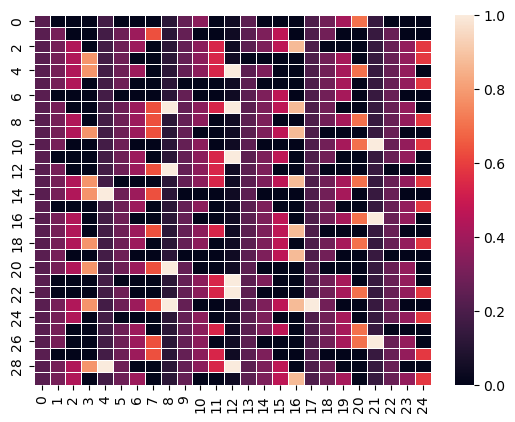

In [14]:
ax = sns.heatmap(win_expectation, linewidth=0.5)
plt.show()

In [15]:
# total marginal probability mass assigned each lottery
win_expectation.sum(axis=0)

array([7.        , 7.00000039, 7.        , 7.00000012, 7.00000018,
       7.00000003, 7.00000012, 6.99999988, 6.99999988, 6.99999985,
       6.99999988, 6.99999958, 6.99999958, 7.00000073, 6.99999988,
       6.99999958, 7.        , 6.99999915, 7.00000048, 7.00000009,
       6.99999988, 6.99999999, 7.00000036, 6.99999991, 7.00000048])

In [16]:
# total marginal probability mass assigned to each attendee
win_expectation.sum(axis=1)

array([3.17807072, 4.37998562, 6.60467123, 5.79576374, 7.81921352,
       4.11164453, 3.18214997, 8.35481648, 6.7643381 , 6.17859673,
       5.83525575, 5.65448983, 5.1254982 , 8.11699151, 5.78434924,
       4.27436193, 6.12427083, 6.28928044, 7.3724189 , 3.70124306,
       5.77178451, 4.930699  , 6.17585055, 8.14798189, 4.75908559,
       5.47461741, 6.2771749 , 5.15752038, 7.23823434, 6.41964113])

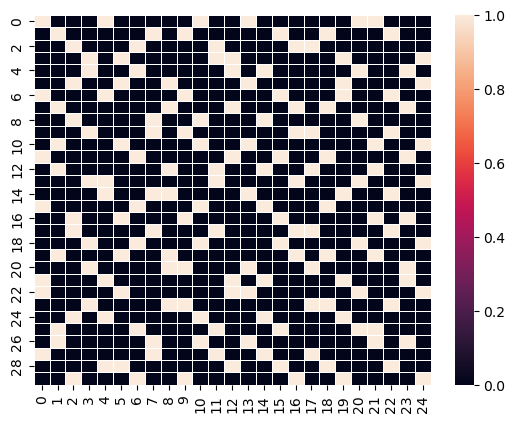

In [17]:
ax = sns.heatmap(winners, linewidth=0.5)
plt.show()